# Oxford Pet 데이터셋 가지고 Localization(BBOX) 하기
+ 본과정에서는 옥스퍼드 펫 데이터셋을 가지고 Localization(객체분류+BBox) 수행합니다.
+ 단순하게, 입력 펫 이미지를 받고 객체의 X, Y 좌표 회귀하는 모델을 만들어 보겠습니다.(이미지 분류는 제외)
+ 이론에서 배운 Regional Proposal 이나 RPN 네트워크 구성은 난이도가 높고 실습에 적용하기 어려우며
+ 주로 Regional Proposal 이나 RPN 네트워크 구성이 포함되고 학습 완료된 Yolo, SSD 모델의 파라미터를 가져와서 Fine Tuning하여 사용하고 있습니다.
+ 여러분들도 처음부터 끝까지 개발할 필요없이 이미 학습완료된 Yolo, SSD 모델을 사용해서 객체탐지 연습해 보시면 되겠습니다.

### 학습목차
1. Import modules
2. 데이터 준비하기
3. 이미지 정보로 DataFrame 만들기 : 이미지패스, label, 위치정보(x,y,w,h) 생성
4. 실제 이미지의 Bbox 그려보자(Localization)
5. CNN 모델로 Localization 학습하기
6. Pretrained MobileNetV2 사용하여 학습하기


### Bounding Box 위치 이해
- Oxford Pet 데이터에서 Bounding Box 위치를 이미지 사이즈에서의 실위치를 xmin, ymin, xmax, ymax 형태로 저장된다.
- 저장된 Bounding Box 위치를 내부 저장시 0 ~ 1 사이의 값으로 변환하여 x, y(중앙), w, h 형태로 저장한다.
- matplotlib Rectangle 이용하여 사각형 그릴 경우, 내부 저장된 BBOX 위치를 이미지 사이즈에서의 실위치로 변환하여 xmin, ymin, w, h 형태로 표현

# 1. import modules

In [1]:
## library import
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import re
from PIL import Image
from glob import glob
import shutil
import xml.etree.ElementTree as et
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 2. 데이터 준비하기

In [4]:
## oxford_pet.zip이 보이는지 확인
glob('oxford_pet.zip')

['oxford_pet.zip']

In [5]:
## 압축풀기
if not os.path.exists('./oxford_pet'):
  !unzip -q oxford_pet.zip -d oxford_pet

In [6]:
## 압축이 풀린 directory 확인
!ls oxford_pet

annotations  images


In [9]:
## directory 정보
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')  # BBOX 정보
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')  # Segmentation 정보

In [10]:
print('data_dir:' ,data_dir)
print('image_dir:' ,image_dir)
print('bbox_dir:', bbox_dir)
print('seg_dir:', seg_dir)

data_dir: /content/oxford_pet
image_dir: /content/oxford_pet/images
bbox_dir: /content/oxford_pet/annotations/xmls
seg_dir: /content/oxford_pet/annotations/trimaps


In [11]:
## image file 수 확인
image_files = [fname for fname in glob(image_dir +  '/*.jpg') if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

1200


In [12]:
## localization을 위한 annotation이 되어 있는 file의 수 확인
## 위의 이미지 갯수보다 annotation XML 파일 갯수가 적다. annotation XML 파일을 기준으로 해야함.

bbox_files = [fname for fname in glob(bbox_dir +  '/*.xml') if os.path.splitext(fname)[-1] == '.xml']
len(bbox_files)

600

In [13]:
## 600 bbox와 매칭되는 이미지를 모우기 위한 새로운 폴더(new_images) 생성

new_image_dir = os.path.join(data_dir, 'new_images')
os.makedirs(new_image_dir, exist_ok=True)

print('new_images:', new_image_dir)

new_images: /content/oxford_pet/new_images


In [14]:
## BB 정보를 가지고 있는 xml 파일 보기
bbox_files[:10]

['/content/oxford_pet/annotations/xmls/american_pit_bull_terrier_158.xml',
 '/content/oxford_pet/annotations/xmls/boxer_125.xml',
 '/content/oxford_pet/annotations/xmls/boxer_143.xml',
 '/content/oxford_pet/annotations/xmls/beagle_111.xml',
 '/content/oxford_pet/annotations/xmls/boxer_113.xml',
 '/content/oxford_pet/annotations/xmls/beagle_103.xml',
 '/content/oxford_pet/annotations/xmls/chihuahua_145.xml',
 '/content/oxford_pet/annotations/xmls/american_bulldog_146.xml',
 '/content/oxford_pet/annotations/xmls/chihuahua_170.xml',
 '/content/oxford_pet/annotations/xmls/boxer_174.xml']

In [15]:
## 600 bbox 리스트 읽어 bbox 이름과 같은 이미지를 new_images 폴더에 복사한다.

for bbox_filename in bbox_files:
  bbox_filename = bbox_filename.split('/')[-1]
  image_name = os.path.splitext(bbox_filename)[0]
  image_file = image_dir + '/' + image_name + '.jpg'
  # print(glob(image_file))
  shutil.copy(image_file, new_image_dir)

In [16]:
## new_images 폴더에 복사된 이미지 건수를 카운트한다.

new_image_files = glob(new_image_dir + '/*')
len(new_image_files)

600

In [17]:
## 600개의 새로 복사된 이미지 리스트

new_image_files[:10]

['/content/oxford_pet/new_images/basset_hound_167.jpg',
 '/content/oxford_pet/new_images/beagle_125.jpg',
 '/content/oxford_pet/new_images/american_bulldog_112.jpg',
 '/content/oxford_pet/new_images/american_bulldog_14.jpg',
 '/content/oxford_pet/new_images/american_pit_bull_terrier_165.jpg',
 '/content/oxford_pet/new_images/basset_hound_158.jpg',
 '/content/oxford_pet/new_images/basset_hound_136.jpg',
 '/content/oxford_pet/new_images/boxer_151.jpg',
 '/content/oxford_pet/new_images/american_pit_bull_terrier_13.jpg',
 '/content/oxford_pet/new_images/chihuahua_100.jpg']

# 3. 이미지 정보로 DataFrame 만들기 : 이미지패스, label, 위치정보(x,y,w,h) 생성

In [18]:
## DataFrame 만들기

pets_df = pd.DataFrame(new_image_files)
pets_df

,0
0,/content/oxford_pet/new_images/basset_hound_16...
1,/content/oxford_pet/new_images/beagle_125.jpg
2,/content/oxford_pet/new_images/american_bulldo...
3,/content/oxford_pet/new_images/american_bulldo...
4,/content/oxford_pet/new_images/american_pit_bu...
...,...
595,/content/oxford_pet/new_images/basset_hound_10...
596,/content/oxford_pet/new_images/basset_hound_11...
597,/content/oxford_pet/new_images/basset_hound_13...
598,/content/oxford_pet/new_images/basset_hound_11...


In [19]:
## 컬럼명 입력

pets_df.columns = ['full_path']
pets_df.head(3)

,full_path
0,/content/oxford_pet/new_images/basset_hound_16...
1,/content/oxford_pet/new_images/beagle_125.jpg
2,/content/oxford_pet/new_images/american_bulldo...


In [20]:
## full_path 컬럼에서 이미지 이름을 분리하여 file_name 컬럼명에 저장

pets_df['file_name'] = pets_df['full_path'].str.split('/').str[-1]
pets_df.head(3)

,full_path,file_name
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg


In [21]:
## file_name 컬럼에서 라벨 분리하여 label 컬럼에 저장

pets_df['label'] = pets_df['file_name'].str.replace('_\d+','').str.split('.').str[0]

<ipython-input-21-0d2a11e4a4ec>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  pets_df['label'] = pets_df['file_name'].str.replace('_\d+','').str.split('.').str[0]


In [22]:
## 이미지 패스에서 레이블 분리 및 저장 확인
pets_df.head(10)

,full_path,file_name,label
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog
3,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_14.jpg,american_bulldog
4,/content/oxford_pet/new_images/american_pit_bu...,american_pit_bull_terrier_165.jpg,american_pit_bull_terrier
5,/content/oxford_pet/new_images/basset_hound_15...,basset_hound_158.jpg,basset_hound
6,/content/oxford_pet/new_images/basset_hound_13...,basset_hound_136.jpg,basset_hound
7,/content/oxford_pet/new_images/boxer_151.jpg,boxer_151.jpg,boxer
8,/content/oxford_pet/new_images/american_pit_bu...,american_pit_bull_terrier_13.jpg,american_pit_bull_terrier
9,/content/oxford_pet/new_images/chihuahua_100.jpg,chihuahua_100.jpg,chihuahua


In [23]:
## 이미지 파일명을 입력으로 받아, 같은 이름과 xml 확장자로 변경해서 리턴하는 함수

def name_convert(col):
  bbox_fname = bbox_dir + '/' + col.replace('jpg','xml')
  return bbox_fname

In [24]:
## name_convert 함수 호출해서 이미지 파일명과 같은 이름의 xml 확장자로 만든다.

pets_df['bbox_full_path'] = pets_df['file_name'].apply(name_convert)
pets_df.head(3)

,full_path,file_name,label,bbox_full_path
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle,/content/oxford_pet/annotations/xmls/beagle_12...
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...


In [25]:
## pets_df 데이터 구조 파악

pets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   full_path       600 non-null    object
 1   file_name       600 non-null    object
 2   label           600 non-null    object
 3   bbox_full_path  600 non-null    object
dtypes: object(4)
memory usage: 18.9+ KB


In [26]:
## label 분포 확인
## 각 class마다 200개 이미지 구성

pets_df['label'].value_counts()

basset_hound                 100
beagle                       100
american_bulldog             100
american_pit_bull_terrier    100
boxer                        100
chihuahua                    100
Name: label, dtype: int64

In [28]:
## bbox_full_path 컬럼의 첫번째 데이터 가져오고 해당 내용 보기

sample_xml_file = pets_df.loc[0, 'bbox_full_path']
print(sample_xml_file)

!cat {sample_xml_file}

/content/oxford_pet/annotations/xmls/basset_hound_167.xml
<annotation><folder>OXIIIT</folder><filename>basset_hound_167.jpg</filename><source><database>OXFORD-IIIT Pet Dataset</database><annotation>OXIIIT</annotation><image>flickr</image></source><size><width>500</width><height>333</height><depth>3</depth></size><segmented>0</segmented><object><name>dog</name><pose>Frontal</pose><truncated>0</truncated><occluded>0</occluded><bndbox><xmin>139</xmin><ymin>70</ymin><xmax>365</xmax><ymax>256</ymax></bndbox><difficult>0</difficult></object></annotation>


In [29]:
## 1. xml Annotation 파일 읽어 이지미 크기와 Bounding box 위치을 파악
## 2. xmin, ymin, xmax, ymax 형태를  x, y(중앙), w, h 형태로 변환하여 저장

def xml_annot_getxywh(xmlfile):
  tree = et.parse(xmlfile)

  width = float(tree.find('./size/width').text)
  height = float(tree.find('./size/height').text)
  xmin = float(tree.find('./object/bndbox/xmin').text)
  ymin = float(tree.find('./object/bndbox/ymin').text)
  xmax = float(tree.find('./object/bndbox/xmax').text)
  ymax = float(tree.find('./object/bndbox/ymax').text)
  xc = (xmin + xmax) / 2.
  yc = (ymin + ymax) / 2.
  x = xc / width
  y = yc / height
  w = (xmax - xmin) / width
  h = (ymax - ymin) / height

  return x, y, w, h

In [30]:
## 샘플 xml 파일에 대한 x, y, w, h 얻어오기

xml_annot_getxywh(sample_xml_file)

(0.504, 0.4894894894894895, 0.452, 0.5585585585585585)

In [31]:
pets_df

,full_path,file_name,label,bbox_full_path
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle,/content/oxford_pet/annotations/xmls/beagle_12...
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...
3,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_14.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...
4,/content/oxford_pet/new_images/american_pit_bu...,american_pit_bull_terrier_165.jpg,american_pit_bull_terrier,/content/oxford_pet/annotations/xmls/american_...
...,...,...,...,...
595,/content/oxford_pet/new_images/basset_hound_10...,basset_hound_108.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...
596,/content/oxford_pet/new_images/basset_hound_11...,basset_hound_11.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...
597,/content/oxford_pet/new_images/basset_hound_13...,basset_hound_135.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...
598,/content/oxford_pet/new_images/basset_hound_11...,basset_hound_114.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...


In [32]:
## xml Annot 파일의 x, y, w, h 위치 정보를 가져와 DataFrame에 저장한다.

pets_df['xywh'] = pets_df['bbox_full_path'].apply(xml_annot_getxywh)
pets_df.head()

,full_path,file_name,label,bbox_full_path,xywh
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.504, 0.4894894894894895, 0.452, 0.558558558..."
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle,/content/oxford_pet/annotations/xmls/beagle_12...,"(0.411, 0.527027027027027, 0.202, 0.3033033033..."
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...,"(0.4219219219219219, 0.27, 0.4594594594594595,..."
3,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_14.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...,"(0.461, 0.4853723404255319, 0.554, 0.853723404..."
4,/content/oxford_pet/new_images/american_pit_bu...,american_pit_bull_terrier_165.jpg,american_pit_bull_terrier,/content/oxford_pet/annotations/xmls/american_...,"(0.6366666666666667, 0.3977777777777778, 0.506..."


In [33]:
## 튜플로 저장된 xywh 컬럼 값들을 하나씩 x, y, w, h 컬럼에 저장한다.

pets_df['x'] = pets_df['xywh'].str[0]
pets_df['y'] = pets_df['xywh'].str[1]
pets_df['w'] = pets_df['xywh'].str[2]
pets_df['h'] = pets_df['xywh'].str[3]

In [34]:
pets_df

,full_path,file_name,label,bbox_full_path,xywh,x,y,w,h
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.504, 0.4894894894894895, 0.452, 0.558558558...",0.504000,0.489489,0.452000,0.558559
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle,/content/oxford_pet/annotations/xmls/beagle_12...,"(0.411, 0.527027027027027, 0.202, 0.3033033033...",0.411000,0.527027,0.202000,0.303303
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...,"(0.4219219219219219, 0.27, 0.4594594594594595,...",0.421922,0.270000,0.459459,0.284000
3,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_14.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...,"(0.461, 0.4853723404255319, 0.554, 0.853723404...",0.461000,0.485372,0.554000,0.853723
4,/content/oxford_pet/new_images/american_pit_bu...,american_pit_bull_terrier_165.jpg,american_pit_bull_terrier,/content/oxford_pet/annotations/xmls/american_...,"(0.6366666666666667, 0.3977777777777778, 0.506...",0.636667,0.397778,0.506667,0.715556
...,...,...,...,...,...,...,...,...,...
595,/content/oxford_pet/new_images/basset_hound_10...,basset_hound_108.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.6763157894736842, 0.375, 0.5263157894736842...",0.676316,0.375000,0.526316,0.630000
596,/content/oxford_pet/new_images/basset_hound_11...,basset_hound_11.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.4706666666666667, 0.312, 0.5306666666666666...",0.470667,0.312000,0.530667,0.452000
597,/content/oxford_pet/new_images/basset_hound_13...,basset_hound_135.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.777, 0.6204013377926422, 0.354, 0.571906354...",0.777000,0.620401,0.354000,0.571906
598,/content/oxford_pet/new_images/basset_hound_11...,basset_hound_114.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.615, 0.5737951807228916, 0.326, 0.533132530...",0.615000,0.573795,0.326000,0.533133


In [35]:
## label에 대한 라벨인코딩 수행
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
pets_df['label_conv'] = le.fit_transform(pets_df['label'])
le.classes_

array(['american_bulldog', 'american_pit_bull_terrier', 'basset_hound',
       'beagle', 'boxer', 'chihuahua'], dtype=object)

In [36]:
pets_df.head(3)

,full_path,file_name,label,bbox_full_path,xywh,x,y,w,h,label_conv
0,/content/oxford_pet/new_images/basset_hound_16...,basset_hound_167.jpg,basset_hound,/content/oxford_pet/annotations/xmls/basset_ho...,"(0.504, 0.4894894894894895, 0.452, 0.558558558...",0.504000,0.489489,0.452000,0.558559,2
1,/content/oxford_pet/new_images/beagle_125.jpg,beagle_125.jpg,beagle,/content/oxford_pet/annotations/xmls/beagle_12...,"(0.411, 0.527027027027027, 0.202, 0.3033033033...",0.411000,0.527027,0.202000,0.303303,3
2,/content/oxford_pet/new_images/american_bulldo...,american_bulldog_112.jpg,american_bulldog,/content/oxford_pet/annotations/xmls/american_...,"(0.4219219219219219, 0.27, 0.4594594594594595,...",0.421922,0.270000,0.459459,0.284000,0


In [37]:
## class와 idx 간의 변환

class2idx = { label : idx for idx, label in enumerate(le.classes_) }
idx2class = { idx :label for idx, label in enumerate(le.classes_) }

In [38]:
print(class2idx)
print(idx2class)

{'american_bulldog': 0, 'american_pit_bull_terrier': 1, 'basset_hound': 2, 'beagle': 3, 'boxer': 4, 'chihuahua': 5}
{0: 'american_bulldog', 1: 'american_pit_bull_terrier', 2: 'basset_hound', 3: 'beagle', 4: 'boxer', 5: 'chihuahua'}


In [39]:
## 이미지 패스 리스트 만들기

images_list = pets_df['full_path'].values

In [40]:
## PIL 라이브러리 사용하여 이미지 파일 리스트에서 이미지 패스에 있는 이미지 읽고 리스트에 넣는다.
## 이미지 resize로 맞추지 않으면 뒤쪽에서 Tensor에러 발생한다.

x_image_list = []

for fname in images_list:
  image = Image.open(fname)
  image = image.resize((224,224))
  image = np.array(image)

  x_image_list.append(image)

x_image_list = np.array(x_image_list)

In [41]:
## 전체 이미지 리스트 형태 보기

x_image_list.shape

(600, 224, 224, 3)

In [44]:
## 이미지 라벨값과 bbox 위치값을 저장한다.

y1_label = pets_df['label_conv'].values
y2_xywh = pets_df[['x', 'y', 'w', 'h']].values

In [45]:
y1_label[:4]

array([2, 3, 0, 0])

In [46]:
y2_xywh[:4]

array([[0.504     , 0.48948949, 0.452     , 0.55855856],
       [0.411     , 0.52702703, 0.202     , 0.3033033 ],
       [0.42192192, 0.27      , 0.45945946, 0.284     ],
       [0.461     , 0.48537234, 0.554     , 0.8537234 ]])

In [47]:
# 하이퍼 파라미터 설정

IMG_SIZE = 224
N_BBOX = len(x_image_list)
N_TRAIN = 500
N_VAL = N_BBOX - N_TRAIN

In [48]:
## Annotation XML 파일 갯수로 리스트 만들고 Shuffle하고 500개 Train set과 100개 Valid set으로 나눈다.

shuffle_list = list(range(N_BBOX))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

In [49]:
## Train set idx 보기
train_idx_list[:10]

[567, 136, 550, 454, 162, 599, 460, 385, 52, 522]

In [50]:
## train 데이터셋 만들기

train_image_list = x_image_list[train_idx_list]
train_y1_label = y1_label[train_idx_list]
train_y2_xywh = y2_xywh[train_idx_list]

In [51]:
## valid 데이터셋 만들기

valid_image_list = x_image_list[val_idx_list]
valid_y1_label = y1_label[val_idx_list]
valid_y2_xywh = y2_xywh[val_idx_list]

In [52]:
train_image_list.shape, valid_image_list.shape

((500, 224, 224, 3), (100, 224, 224, 3))

In [53]:
## 이미지와 X/Y/W/H 정보를 가지고 Train / Valid Dataset 만들기

train_dataset_image = tf.data.Dataset.from_tensor_slices((train_image_list, train_y2_xywh))
valid_dataset_image = tf.data.Dataset.from_tensor_slices((valid_image_list, valid_y2_xywh))

In [55]:
# from_tensor_slices 읽어들인 이미지 리스트와 1개 y값들을 배치, 셔플한다.

# train_dataset = train_dataset_image.batch(16).shuffle(1000).repeat()
# valid_dataset = valid_dataset_image.batch(16).repeat()

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset_image.batch(16).shuffle(1000).cache().prefetch(AUTOTUNE)
valid_dataset = valid_dataset_image.batch(16).cache().prefetch(AUTOTUNE)

# 4. 실제 이미지의 Bbox 그려보자(Localization)

In [56]:
## Hyper Parameters

N_CLASS = len(class2idx)
N_EPOCHS = 40
N_BATCH = 16
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [57]:
## valid_dataset에서 1개 가져와 분석해 보자
## 이미지와 라벨로 받고 라벨은 다시 실제 라벨과 x,y,w,h 위치 값으로 나뉜다.

for image, label in valid_dataset.take(1):
  print(image.shape)
  print(label.shape)


(16, 224, 224, 3)
(16, 4)


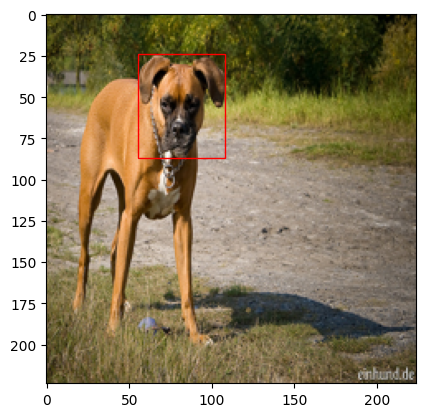

In [58]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, label in valid_dataset.take(1):

    ''' matplotlib Rectangle 이용하여 사각형 그릴 경우,
    그림을 그리기 위해서 bbox의 왼쪽 아래 (xmin, ymin) 꼭지점 좌표를 계산하고,
    xmin, ymin, w, h 각각을 image size에 맞게 scaling'''

    # x, y(중앙), w, h 형태를 xmin, ymin, w, h 형태로 변환해야 함.

    x = label[:,0]
    y = label[:,1]
    w = label[:,2]
    h = label[:,3]
    xmin = x[0].numpy() - w[0].numpy()/2.
    ymin = y[0].numpy() - h[0].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[0].numpy() * IMG_SIZE)
    rect_h = int(h[0].numpy() * IMG_SIZE)

    ## 그림 그리기
    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)
    plt.imshow(image[0])
    plt.show()

# 5. CNN 모델로 Localization 학습하기

In [59]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME',
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(tf.keras.layers.MaxPool2D(padding='SAME'))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(tf.keras.layers.MaxPool2D(padding='SAME'))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(tf.keras.layers.MaxPool2D(padding='SAME'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(tf.keras.layers.MaxPool2D(padding='SAME'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(tf.keras.layers.MaxPool2D(padding='SAME'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
    return model

In [61]:
## Create model, compile & summary
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

In [ ]:
def loss_fn(y_true, y_pred):
  return tf.keras.losses.MeanSquaredError()(y_true, y_pred)

In [62]:
## learning rate scheduing
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.5,
                                                          staircase=True)

# model.compile(optimizer='adam', loss='mse', metrics=['accuracy']) > loss='mse'로 간단하게 할수도 있음.
# 여기서는 직접 loss function을 만들수 있음을 보여줌
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [63]:
## callbacks : EarlyStopping, ModelCheckpoint
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('best_model_{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [64]:
## Train!
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=valid_dataset,
         validation_steps=validation_steps,
         callbacks=[es, mc])

Epoch 1/40
32/31 [==============================] - ETA: -1s - loss: 0.2450 - accuracy: 0.3800
Epoch 1: val_loss improved from inf to 0.23235, saving model to best_model_0.23.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 56s 2s/step - loss: 0.2450 - accuracy: 0.3800 - val_loss: 0.2323 - val_accuracy: 0.4500
Epoch 2/40



Epoch 2: val_loss did not improve from 0.23235
31/31 [==============================] - 5s 161ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.2323 - val_accuracy: 0.4500


# 6. Pretrained MobileNetV2 사용하여 학습하기

In [65]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [66]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [67]:
mobilenetv2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [68]:
def create_mv_model():
  model = models.Sequential()
  model.add(mobilenetv2)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(4, activation='sigmoid'))
  return model

In [69]:
## Create model, compile & summary
model = create_mv_model()

## learning rate scheduing
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [70]:
## callbacks : EarlyStopping, ModelCheckpoint
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint('best_model_{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1)

In [71]:
## Train!
model.fit(train_dataset,
         epochs=N_EPOCHS,
         steps_per_epoch=steps_per_epoch,
         validation_data=valid_dataset,
         validation_steps=validation_steps,
         callbacks=[es, mc])

Epoch 1/40
32/31 [==============================] - ETA: -1s - loss: 2.7411 - accuracy: 0.4220
Epoch 1: val_loss improved from inf to 5.49024, saving model to best_model_5.49.h5
31/31 [==============================] - 61s 2s/step - loss: 2.7411 - accuracy: 0.4220 - val_loss: 5.4902 - val_accuracy: 0.1600
Epoch 2/40



Epoch 2: val_loss did not improve from 5.49024
31/31 [==============================] - 6s 177ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 5.4902 - val_accuracy: 0.1600


1/1 [==============================] - 1s 1s/step


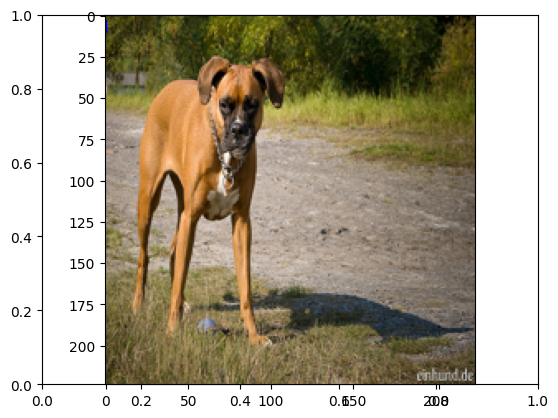

1/1 [==============================] - 0s 296ms/step


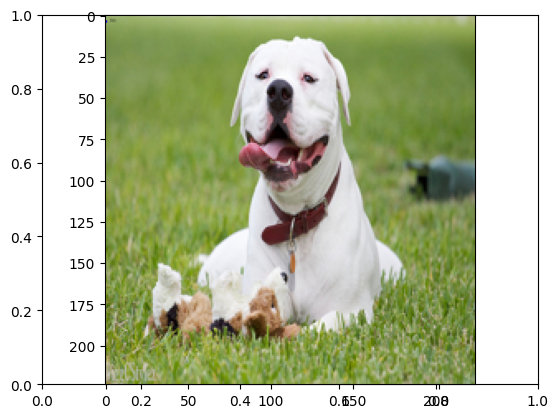

1/1 [==============================] - 0s 275ms/step


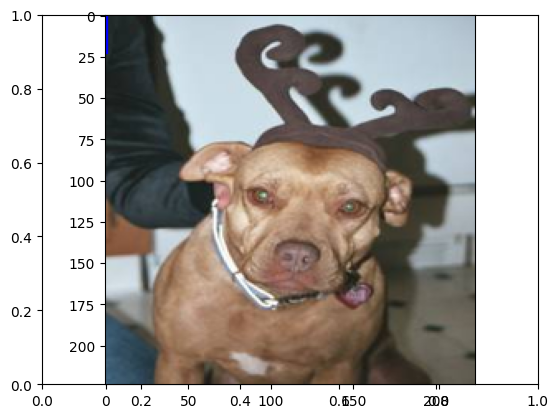

1/1 [==============================] - 0s 275ms/step


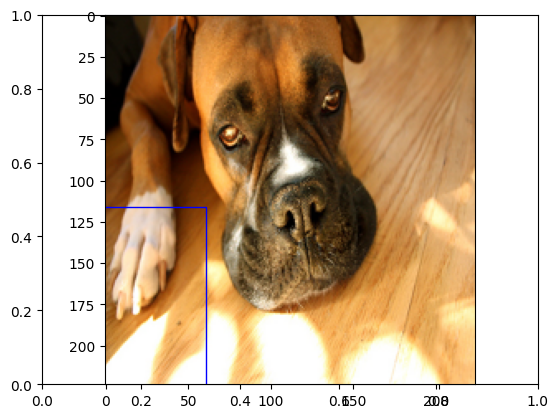

1/1 [==============================] - 0s 290ms/step


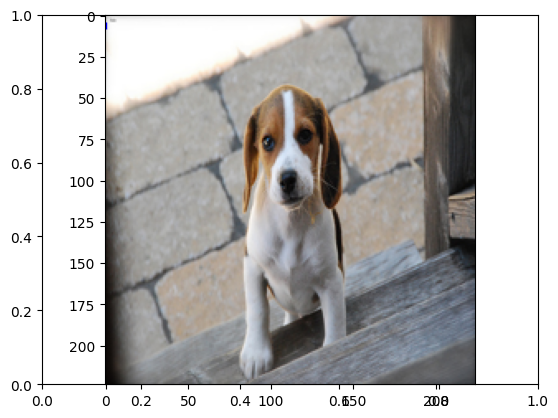

1/1 [==============================] - 0s 290ms/step


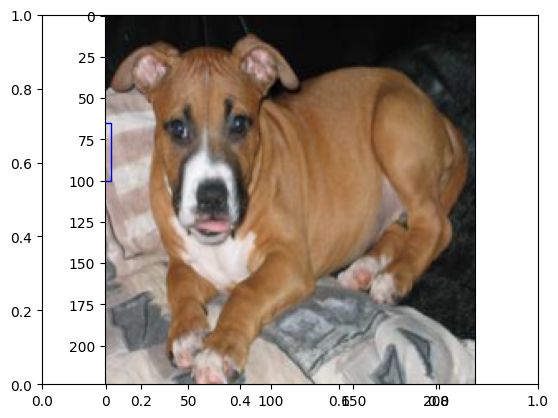

1/1 [==============================] - 0s 80ms/step


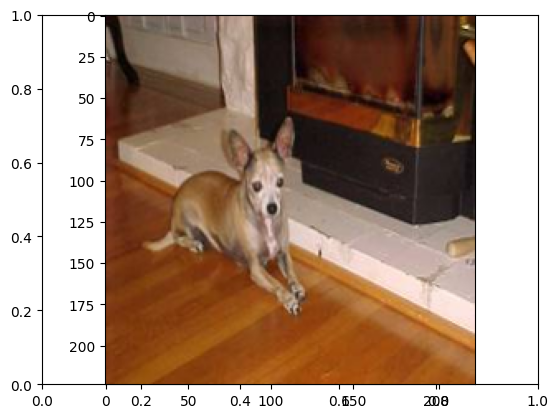

In [72]:
## 예측한 bounding box와 ground truth box를 image에 같이 표시
## 정답은 빨간색 box, 예측은 파란색 box

idx = 0
num_imgs = validation_steps
for val_data, val_gt in valid_dataset.take(num_imgs):
    ## 정답 box 그리기 : 빨강박스
    x = val_gt[:,0]
    y = val_gt[:,1]
    w = val_gt[:,2]
    h = val_gt[:,3]
    xmin = x[idx].numpy() - w[idx].numpy()/2.
    ymin = y[idx].numpy() - h[idx].numpy()/2.
    rect_x = int(xmin * IMG_SIZE)
    rect_y = int(ymin * IMG_SIZE)
    rect_w = int(w[idx].numpy() * IMG_SIZE)
    rect_h = int(h[idx].numpy() * IMG_SIZE)

    rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
    plt.axes().add_patch(rect)

    ## 예측 box 그리기 : 파랑박스
    ## validation set에 대해서 bounding box 예측
    prediction = model.predict(val_data)
    pred_x = prediction[:,0]
    pred_y = prediction[:,1]
    pred_w = prediction[:,2]
    pred_h = prediction[:,3]
    pred_xmin = pred_x[idx] - pred_w[idx]/2.
    pred_ymin = pred_y[idx] - pred_h[idx]/2.
    pred_rect_x = int(pred_xmin * IMG_SIZE)
    pred_rect_y = int(pred_ymin * IMG_SIZE)
    pred_rect_w = int(pred_w[idx] * IMG_SIZE)
    pred_rect_h = int(pred_h[idx] * IMG_SIZE)

    pred_rect = Rectangle((pred_rect_x, pred_rect_y), pred_rect_w, pred_rect_h,
                         fill=False, color='blue')
    plt.axes().add_patch(pred_rect)

    ## image와 bbox 함께 출력
    plt.imshow(val_data[idx])
    plt.show()

## 배운 내용 정리
1. Oxford Pet 데이터셋 가지고 Localization(Bbox) 실습해 보았습니다.
2. 이미지 파일과 BBOX 정보 xml 파일을 가지고 DataFrame 만들기 : 이미지패스, label, 위치정보(x,y,w,h) 생성
3. 실제 이미지의 Bbox 그려 보았습니다.(Localization)
4. CNN 모델로 Localization 학습하고
5. 성능향상을 위해 Pretrained MobileNetV2 사용하여 학습해 보았습니다.
6. Localization BBox 찾는 객체탐지가 생각보다 성능이 잘 나오지 않음을 알수 있었습니다.